In [1]:
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
#from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.datasets import cifar10

from kerasutils import hits_and_misses, describe_model

import matplotlib.pyplot as plt
import numpy as np

import random

/home/ubuntu/.virtualenvs/gpu2/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/.virtualenvs/gpu2/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

In [3]:
trainX = trainX / 255.0
testX = testX / 255.0

In [4]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)
print(trainY[0])
print(testY[1])

input_shape = trainX[0,:,:,:].shape
print(input_shape)
#print(trainX[0,:,:,:])

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)
[6]
[8]
(32, 32, 3)


In [5]:
# Transform labels from int to one-hot vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

print(trainY.shape)
print(testY.shape)
n_classes = trainY.shape[1]

(50000, 10)
(10000, 10)


In [15]:
# CNN architecture with Keras
model = Sequential()
model.add(Conv2D(input_shape=trainX[0,:,:,:].shape, filters=32, 
                 use_bias=True, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
#model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=96, use_bias=False, kernel_size=(5,5), strides=2))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=96, use_bias=False, kernel_size=(5,5), strides=2))
model.add(Activation('relu'))
model.add(Dropout(0.2))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Conv2D(filters=64, use_bias=False, kernel_size=(3,3), strides=3))
#model.add(Activation('relu'))
#model.add(Dropout(0.05))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Conv2D(filters=64, use_bias=False, kernel_size=(3,3), strides=2))
#model.add(Activation('relu'))
#model.add(Dropout(0.3))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
# Deeper architecture
# https://arxiv.org/pdf/1412.6806.pdf
model = Sequential()
model.add(Conv2D(input_shape=trainX[0,:,:,:].shape, filters=96, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(Conv2D(filters=96, kernel_size=(3,3), strides=2))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=192, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(Conv2D(filters=192, kernel_size=(3,3), strides=2))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256))
model.add(Activation('relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(n_classes, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
basefilename = 'cifar10-cnn'
filepath=basefilename+".{acc:.4f}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
n_epochs = 500
batch_size = 256

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zoom_range=0.2,     # zoom image
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(trainX)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(trainX, trainY,
                                 batch_size=batch_size),
                                 epochs=n_epochs,
                                 validation_data=(testX, testY))

print('Done!!!')

Using real-time data augmentation.
Epoch 1/500
196/196 [==============================] - 23s 117ms/step - loss: 1.7835 - acc: 0.3463 - val_loss: 1.3726 - val_acc: 0.4972
Epoch 2/500
196/196 [==============================] - 22s 111ms/step - loss: 1.4484 - acc: 0.4771 - val_loss: 1.2765 - val_acc: 0.5399
Epoch 3/500
196/196 [==============================] - 22s 112ms/step - loss: 1.3114 - acc: 0.5322 - val_loss: 1.1251 - val_acc: 0.5996
Epoch 4/500
196/196 [==============================] - 22s 112ms/step - loss: 1.2311 - acc: 0.5629 - val_loss: 0.9650 - val_acc: 0.6562
Epoch 5/500
196/196 [==============================] - 22s 112ms/step - loss: 1.1595 - acc: 0.5897 - val_loss: 1.0204 - val_acc: 0.6310
Epoch 6/500
196/196 [==============================] - 22s 112ms/step - loss: 1.1226 - acc: 0.6027 - val_loss: 0.9367 - val_acc: 0.6681
Epoch 7/500
196/196 [==============================] - 22s 112ms/step - loss: 1.0844 - acc: 0.6152 - val_loss: 0.9365 - val_acc: 0.6731
Epoch 8/500
1

196/196 [==============================] - 22s 112ms/step - loss: 0.7365 - acc: 0.7438 - val_loss: 0.5918 - val_acc: 0.7967
Epoch 61/500
196/196 [==============================] - 22s 113ms/step - loss: 0.7378 - acc: 0.7422 - val_loss: 0.6083 - val_acc: 0.7965
Epoch 62/500
196/196 [==============================] - 22s 113ms/step - loss: 0.7358 - acc: 0.7459 - val_loss: 0.6348 - val_acc: 0.7848
Epoch 63/500
196/196 [==============================] - 22s 111ms/step - loss: 0.7387 - acc: 0.7431 - val_loss: 0.5813 - val_acc: 0.8054
Epoch 64/500
196/196 [==============================] - 22s 112ms/step - loss: 0.7301 - acc: 0.7479 - val_loss: 0.6413 - val_acc: 0.7799
Epoch 65/500
196/196 [==============================] - 22s 112ms/step - loss: 0.7336 - acc: 0.7454 - val_loss: 0.5931 - val_acc: 0.7988
Epoch 66/500
196/196 [==============================] - 22s 111ms/step - loss: 0.7258 - acc: 0.7468 - val_loss: 0.6193 - val_acc: 0.7928
Epoch 67/500
196/196 [==============================] 

Epoch 120/500
196/196 [==============================] - 22s 111ms/step - loss: 0.6674 - acc: 0.7680 - val_loss: 0.5414 - val_acc: 0.8205
Epoch 121/500
196/196 [==============================] - 22s 111ms/step - loss: 0.6674 - acc: 0.7675 - val_loss: 0.5283 - val_acc: 0.8207
Epoch 122/500
196/196 [==============================] - 22s 111ms/step - loss: 0.6633 - acc: 0.7718 - val_loss: 0.5135 - val_acc: 0.8285
Epoch 123/500
196/196 [==============================] - 22s 112ms/step - loss: 0.6658 - acc: 0.7699 - val_loss: 0.5273 - val_acc: 0.8212
Epoch 124/500
196/196 [==============================] - 22s 113ms/step - loss: 0.6612 - acc: 0.7727 - val_loss: 0.5502 - val_acc: 0.8183
Epoch 125/500
196/196 [==============================] - 22s 112ms/step - loss: 0.6622 - acc: 0.7717 - val_loss: 0.5195 - val_acc: 0.8275
Epoch 126/500
196/196 [==============================] - 22s 112ms/step - loss: 0.6559 - acc: 0.7725 - val_loss: 0.5469 - val_acc: 0.8170
Epoch 127/500
196/196 [===========

196/196 [==============================] - 22s 113ms/step - loss: 0.6247 - acc: 0.7837 - val_loss: 0.5581 - val_acc: 0.8143
Epoch 180/500
196/196 [==============================] - 22s 111ms/step - loss: 0.6234 - acc: 0.7835 - val_loss: 0.5401 - val_acc: 0.8224
Epoch 181/500
196/196 [==============================] - 22s 112ms/step - loss: 0.6278 - acc: 0.7833 - val_loss: 0.5099 - val_acc: 0.8298
Epoch 182/500
196/196 [==============================] - 22s 113ms/step - loss: 0.6299 - acc: 0.7820 - val_loss: 0.5138 - val_acc: 0.8301
Epoch 183/500
196/196 [==============================] - 22s 112ms/step - loss: 0.6255 - acc: 0.7820 - val_loss: 0.5301 - val_acc: 0.8212
Epoch 184/500
196/196 [==============================] - 22s 112ms/step - loss: 0.6308 - acc: 0.7822 - val_loss: 0.5051 - val_acc: 0.8306
Epoch 185/500
196/196 [==============================] - 22s 112ms/step - loss: 0.6197 - acc: 0.7854 - val_loss: 0.4771 - val_acc: 0.8374
Epoch 186/500
196/196 [=========================

196/196 [==============================] - 22s 111ms/step - loss: 0.5977 - acc: 0.7918 - val_loss: 0.5015 - val_acc: 0.8336
Epoch 239/500
196/196 [==============================] - 22s 113ms/step - loss: 0.6046 - acc: 0.7910 - val_loss: 0.4739 - val_acc: 0.8385
Epoch 240/500
196/196 [==============================] - 22s 112ms/step - loss: 0.5962 - acc: 0.7918 - val_loss: 0.4952 - val_acc: 0.8384
Epoch 241/500
196/196 [==============================] - 22s 111ms/step - loss: 0.5986 - acc: 0.7931 - val_loss: 0.4655 - val_acc: 0.8410
Epoch 242/500
196/196 [==============================] - 22s 112ms/step - loss: 0.6010 - acc: 0.7909 - val_loss: 0.5165 - val_acc: 0.8264
Epoch 243/500
196/196 [==============================] - 22s 113ms/step - loss: 0.6057 - acc: 0.7917 - val_loss: 0.4800 - val_acc: 0.8399
Epoch 244/500
196/196 [==============================] - 22s 111ms/step - loss: 0.5979 - acc: 0.7933 - val_loss: 0.5043 - val_acc: 0.8322
Epoch 245/500
196/196 [=========================

196/196 [==============================] - 22s 111ms/step - loss: 0.5781 - acc: 0.7976 - val_loss: 0.4652 - val_acc: 0.8456
Epoch 298/500
196/196 [==============================] - 22s 111ms/step - loss: 0.5876 - acc: 0.7969 - val_loss: 0.4848 - val_acc: 0.8366
Epoch 299/500
196/196 [==============================] - 22s 111ms/step - loss: 0.5814 - acc: 0.7983 - val_loss: 0.5136 - val_acc: 0.8262
Epoch 300/500
196/196 [==============================] - 22s 112ms/step - loss: 0.5808 - acc: 0.7998 - val_loss: 0.4525 - val_acc: 0.8488
Epoch 301/500
196/196 [==============================] - 22s 113ms/step - loss: 0.5845 - acc: 0.7981 - val_loss: 0.4840 - val_acc: 0.8395
Epoch 302/500
196/196 [==============================] - 22s 111ms/step - loss: 0.5797 - acc: 0.7989 - val_loss: 0.4589 - val_acc: 0.8424
Epoch 303/500
196/196 [==============================] - 22s 112ms/step - loss: 0.5863 - acc: 0.7974 - val_loss: 0.4796 - val_acc: 0.8394
Epoch 304/500
196/196 [=========================

196/196 [==============================] - 22s 112ms/step - loss: 0.5647 - acc: 0.8028 - val_loss: 0.4683 - val_acc: 0.8434
Epoch 362/500
196/196 [==============================] - 22s 111ms/step - loss: 0.5673 - acc: 0.8030 - val_loss: 0.4544 - val_acc: 0.8471
Epoch 363/500
196/196 [==============================] - 22s 112ms/step - loss: 0.5610 - acc: 0.8050 - val_loss: 0.4524 - val_acc: 0.8480
Epoch 364/500
196/196 [==============================] - 22s 111ms/step - loss: 0.5690 - acc: 0.8024 - val_loss: 0.4617 - val_acc: 0.8441
Epoch 365/500
196/196 [==============================] - 22s 111ms/step - loss: 0.5601 - acc: 0.8043 - val_loss: 0.4824 - val_acc: 0.8386
Epoch 366/500
196/196 [==============================] - 22s 111ms/step - loss: 0.5651 - acc: 0.8051 - val_loss: 0.4458 - val_acc: 0.8509
Epoch 367/500
196/196 [==============================] - 22s 112ms/step - loss: 0.5618 - acc: 0.8048 - val_loss: 0.4619 - val_acc: 0.8443
Epoch 368/500
196/196 [=========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



196/196 [==============================] - 22s 112ms/step - loss: 0.5538 - acc: 0.8080 - val_loss: 0.4789 - val_acc: 0.8399
Epoch 419/500
196/196 [==============================] - 22s 112ms/step - loss: 0.5595 - acc: 0.8065 - val_loss: 0.4709 - val_acc: 0.8450
Epoch 420/500
196/196 [==============================] - 22s 112ms/step - loss: 0.5502 - acc: 0.8067 - val_loss: 0.4547 - val_acc: 0.8493
Epoch 421/500
196/196 [==============================] - 22s 112ms/step - loss: 0.5577 - acc: 0.8089 - val_loss: 0.4960 - val_acc: 0.8351
Epoch 422/500
196/196 [==============================] - 22s 111ms/step - loss: 0.5467 - acc: 0.8094 - val_loss: 0.4559 - val_acc: 0.8531
Epoch 423/500
196/196 [==============================] - 22s 111ms/step - loss: 0.5462 - acc: 0.8108 - val_loss: 0.5113 - val_acc: 0.8305
Epoch 424/500
196/196 [==============================] - 22s 114ms/step - loss: 0.5554 - acc: 0.8080 - val_loss: 0.4565 - val_acc: 0.8495
Epoch 425/500
196/196 [=========================

In [7]:
n_epochs = 25
batch_size = 256
callbacks_list = None
H = model.fit(trainX, trainY, validation_data=(testX, testY), 
              epochs=n_epochs, batch_size=batch_size, callbacks=callbacks_list)
print('Done!!!')

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 16s 322us/step - loss: 1.6566 - acc: 0.3988 - val_loss: 1.3428 - val_acc: 0.5170
Epoch 2/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.3235 - acc: 0.5295 - val_loss: 1.1718 - val_acc: 0.5841
Epoch 3/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.1789 - acc: 0.5852 - val_loss: 1.0722 - val_acc: 0.6203
Epoch 4/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.0708 - acc: 0.6237 - val_loss: 0.9994 - val_acc: 0.6508
Epoch 5/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.0061 - acc: 0.6453 - val_loss: 0.9809 - val_acc: 0.6576
Epoch 6/25
50000/50000 [==============================] - 8s 158us/step - loss: 0.9378 - acc: 0.6709 - val_loss: 0.9432 - val_acc: 0.6698
Epoch 7/25
50000/50000 [==============================] - 8s 158us/step - loss: 0.8797 - acc: 0.6901 - val_loss: 0.9138 -

In [8]:
# Evaluate TEST model class prediction accuracy
print("[INFO] Evaluating network...")
predictions = model.predict(testX, batch_size=batch_size)
target_names = [str(x) for x in lb.classes_]
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=target_names))


[INFO] Evaluating network...
             precision    recall  f1-score   support

          0       0.78      0.83      0.80      1000
          1       0.85      0.92      0.88      1000
          2       0.77      0.58      0.66      1000
          3       0.66      0.54      0.59      1000
          4       0.72      0.72      0.72      1000
          5       0.72      0.63      0.67      1000
          6       0.69      0.91      0.78      1000
          7       0.81      0.83      0.82      1000
          8       0.85      0.87      0.86      1000
          9       0.82      0.86      0.84      1000

avg / total       0.77      0.77      0.76     10000



In [9]:
# Evaluate TRAIN model class prediction accuracy
print("[INFO] Evaluating network...")
trainPreds = model.predict(trainX, batch_size=batch_size)
target_names = [str(x) for x in lb.classes_]
print(classification_report(trainY.argmax(axis=1),
                            trainPreds.argmax(axis=1),
                            target_names=target_names))

[INFO] Evaluating network...
             precision    recall  f1-score   support

          0       0.84      0.86      0.85      5000
          1       0.87      0.94      0.90      5000
          2       0.83      0.66      0.74      5000
          3       0.71      0.60      0.65      5000
          4       0.77      0.78      0.77      5000
          5       0.76      0.66      0.71      5000
          6       0.72      0.93      0.81      5000
          7       0.83      0.86      0.84      5000
          8       0.89      0.91      0.90      5000
          9       0.85      0.89      0.87      5000

avg / total       0.81      0.81      0.80     50000



In [14]:
from kerasutils import describe_model

describe_model(model)

Layer 0: <class 'keras.layers.convolutional.Conv2D'>
    input=(None, 32, 32, 3)
    output=(None, 30, 30, 32)
    act=<function linear at 0x7f3149bcdae8>
    strides=(1, 1)
Layer 1: <class 'keras.layers.core.Activation'>
    input=(None, 30, 30, 32)
    output=(None, 30, 30, 32)
    act=<function relu at 0x7f3149bcd8c8>
Layer 2: <class 'keras.layers.core.Dropout'>
    input=(None, 30, 30, 32)
    output=(None, 30, 30, 32)
    rate=0.2
Layer 3: <class 'keras.layers.convolutional.Conv2D'>
    input=(None, 30, 30, 32)
    output=(None, 13, 13, 96)
    act=<function linear at 0x7f3149bcdae8>
    strides=(2, 2)
Layer 4: <class 'keras.layers.core.Activation'>
    input=(None, 13, 13, 96)
    output=(None, 13, 13, 96)
    act=<function relu at 0x7f3149bcd8c8>
Layer 5: <class 'keras.layers.core.Dropout'>
    input=(None, 13, 13, 96)
    output=(None, 13, 13, 96)
    rate=0.2
Layer 6: <class 'keras.layers.core.Flatten'>
    input=(None, 13, 13, 96)
    output=(None, 16224)
Layer 7: <class 'ker

In [47]:
layer = model.layers[2]
layer.rate = 0.1

print(layer.rate)
print(layer.get_config())

0.1
{'seed': None, 'noise_shape': None, 'rate': 0.1, 'trainable': True, 'name': 'dropout_1'}


In [11]:
preds = predictions.argmax(axis=1)
targets = testY.argmax(axis=1)
hits, misses = hits_and_misses(preds, targets)
print('{0} hits, {1} misses ({2}%)'.format(len(hits), len(misses), len(hits)/float(len(predictions))))

6775 hits, 3225 misses (0.6775%)


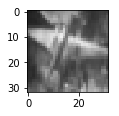

Target: 0, Predicted: 3


In [16]:
# Look at examples of misses
from imageutils import bgr2rgb
idx = misses[random.randint(0,len(misses))]
im = testX[idx]
plt.figure(figsize=(1.5,1.5))
plt.imshow(bgr2rgb(im))
plt.show()
print('Target: {0}, Predicted: {1}'.format(targets[idx], preds[idx]))


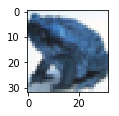

Target: 6, Predicted: 6


In [17]:
# Look at examples of hits
from imageutils import bgr2rgb
idx = hits[random.randint(0,len(hits))]
im = testX[idx]
plt.figure(figsize=(1.5,1.5))
plt.imshow(bgr2rgb(im))
plt.show()
print('Target: {0}, Predicted: {1}'.format(targets[idx], preds[idx]))